In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/urbansound8k/UrbanSound8K.csv
/kaggle/input/urbansound8k/fold7/164797-2-0-8.wav
/kaggle/input/urbansound8k/fold7/177537-7-2-0.wav
/kaggle/input/urbansound8k/fold7/177729-0-0-68.wav
/kaggle/input/urbansound8k/fold7/6902-2-0-18.wav
/kaggle/input/urbansound8k/fold7/518-4-0-2.wav
/kaggle/input/urbansound8k/fold7/146845-0-0-2.wav
/kaggle/input/urbansound8k/fold7/116485-3-2-4.wav
/kaggle/input/urbansound8k/fold7/518-4-0-3.wav
/kaggle/input/urbansound8k/fold7/44737-5-0-2.wav
/kaggle/input/urbansound8k/fold7/201988-5-0-3.wav
/kaggle/input/urbansound8k/fold7/181102-9-0-50.wav
/kaggle/input/urbansound8k/fold7/99812-1-6-0.wav
/kaggle/input/urbansound8k/fold7/39857-5-0-0.wav
/kaggle/input/urbansound8k/fold7/61503-2-0-6.wav
/kaggle/input/urbansound8k/fold7/162728-1-0-0.wav
/kaggle/input/urbansound8k/fold7/89443-9-0-48.wav
/kaggle/input/urbansound8k/fold7/168846-5-1-13.wav
/kaggle/input/urbansound8k/fold7/149193-5-0-2.wav
/kaggle/input/urbansound8k/fold7/71529-4-0-2.wav
/kaggle/input/u

In [2]:
import os
import pandas as pd
import librosa 
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import IPython.display as idp
from tensorflow.keras.models import load_model
import cv2
import warnings
warnings.simplefilter("ignore")
from sklearn.metrics import classification_report,confusion_matrix

2025-07-13 16:04:07.114710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752422647.376092      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752422647.449284      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# MFCC and Mel-Spectrogram Visualization (Single Example)

In [3]:
audio_path = '/kaggle/input/urbansound8k/fold1/101415-3-0-2.wav'


y, sr = librosa.load(audio_path, sr=None)

# MFCC
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

# Mel Spectrogram
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)


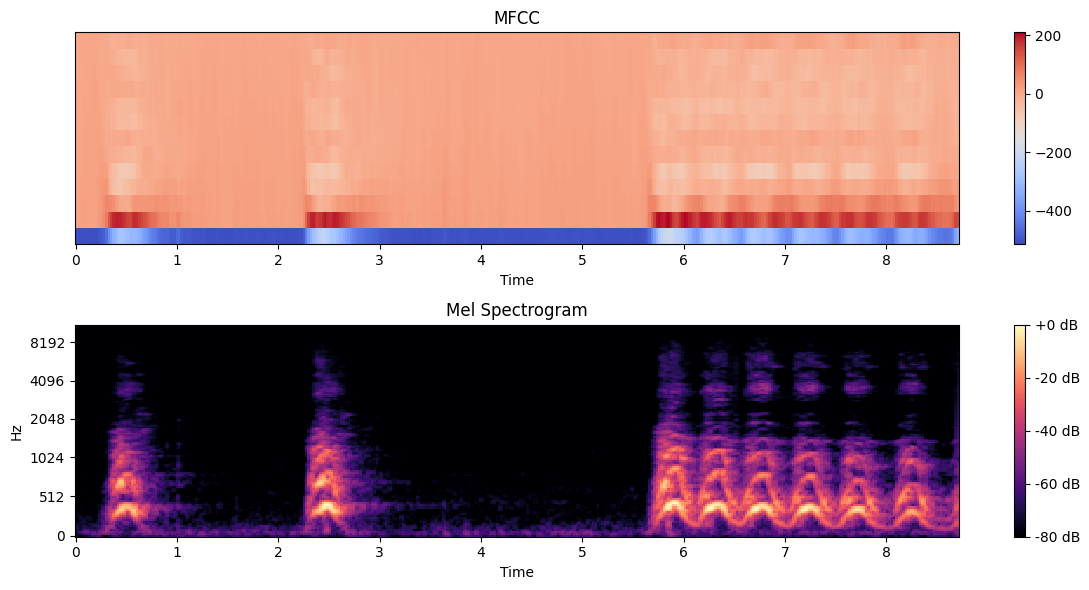

In [4]:
plt.figure(figsize=(12, 6))

plt.subplot(2,1,1)
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')

plt.subplot(2,1,2)
librosa.display.specshow(mel_spec_db, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')

plt.tight_layout()
plt.show()

# Preparing Audio Data for CNN Input

In [6]:
audio_dataset_path = '../input/urbansound8k/'
df = pd.read_csv('../input/urbansound8k/UrbanSound8K.csv')

In [7]:
df.head(5)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [8]:
classes = df['class'].unique()
print("Classes are: ",classes)
print("# of Classes are: ",classes.shape[0])

Classes are:  ['dog_bark' 'children_playing' 'car_horn' 'air_conditioner' 'street_music'
 'gun_shot' 'siren' 'engine_idling' 'jackhammer' 'drilling']
# of Classes are:  10


In [34]:
# Extract and preprocess MFCC features from each audio file to build the input dataset for training

X = []
y = []

# Target dimensions for resizing MFCC features
#up_width and up_height are chosen based on the dataset's characteristics
up_width = 173
up_height = 40


for data in df.iterrows():
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(data[1][5])+'/',str(data[1][0]))

    # Load the audio file (raw waveform and sample rate)
    raw , sr = librosa.load(file_name)

    # Extract MFCC (Mel-Frequency Cepstral Coefficients) features with 40 coefficients
    X_ = librosa.feature.mfcc(y=raw, sr=sr, n_mfcc=40)

    # Resize the MFCC matrix to a fixed size (173 x 40) for consistent input shape
    up_points = (up_width, up_height)
    X_ = cv2.resize(X_, up_points, interpolation= cv2.INTER_LINEAR)

    # Append the processed feature matrix and label to their respective lists
    X.append(X_)
    y.append(data[1][7])

In [35]:
# Convert lists of MFCC features and labels to NumPy arrays for efficient computation
X = np.array(X)
y = np.array(y)

In [36]:
y = to_categorical(le.fit_transform(y))

In [37]:
# Reshape MFCC input data to include a channel dimension (required for CNN input) (4D)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

In [38]:
#Train test split
X_train , X_test , y_train , y_test = train_test_split(X , y ,test_size=0.2, random_state=42)

In [39]:
INPUTSHAPE = (up_height,up_width,1)

# Defining and Training the CNN Model

In [40]:
model =  models.Sequential([
    
                          layers.Conv2D(32 , (3,3),activation = 'relu',padding='valid', input_shape = INPUTSHAPE),  
                          layers.MaxPooling2D(2, padding='same'),
                          
                          layers.Conv2D(128, (3,3), activation='relu',padding='valid'),
                          layers.MaxPooling2D(2, padding='same'),
                          layers.Dropout(0.3),
                          
                          layers.Conv2D(128, (3,3), activation='relu',padding='valid'),
                          layers.MaxPooling2D(2, padding='same'),
                          layers.Dropout(0.3),
                          
                          layers.GlobalAveragePooling2D(),
                          layers.Dense(256 , activation = 'relu'),
                          layers.Dense(10 , activation = 'softmax')
])
opt = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 38, 171, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 19, 86, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 17, 84, 128)         │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 9, 42, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 9, 42, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 7, 40, 128)          │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 4, 20, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 4, 20, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 220,490 (861.29 KB)

 Trainable params: 220,490 (861.29 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
batch_size = 8
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False)

history = model.fit(X_train,y_train ,
            validation_data=(X_test,y_test),
            epochs=7,
            callbacks = [callback],batch_size=batch_size)

Epoch 1/7
874/874 ━━━━━━━━━━━━━━━━━━━━ 73s 80ms/step - accuracy: 0.3478 - loss: 1.8653 - val_accuracy: 0.6898 - val_loss: 0.9372
Epoch 2/7
874/874 ━━━━━━━━━━━━━━━━━━━━ 69s 79ms/step - accuracy: 0.6712 - loss: 0.9732 - val_accuracy: 0.7670 - val_loss: 0.6998
Epoch 3/7
874/874 ━━━━━━━━━━━━━━━━━━━━ 69s 79ms/step - accuracy: 0.7580 - loss: 0.7049 - val_accuracy: 0.7928 - val_loss: 0.6292
Epoch 4/7
874/874 ━━━━━━━━━━━━━━━━━━━━ 69s 79ms/step - accuracy: 0.8297 - loss: 0.5253 - val_accuracy: 0.8203 - val_loss: 0.5477
Epoch 5/7
874/874 ━━━━━━━━━━━━━━━━━━━━ 82s 79ms/step - accuracy: 0.8481 - loss: 0.4526 - val_accuracy: 0.8598 - val_loss: 0.4317
Epoch 6/7
874/874 ━━━━━━━━━━━━━━━━━━━━ 69s 79ms/step - accuracy: 0.8692 - loss: 0.3796 - val_accuracy: 0.8638 - val_loss: 0.4230
Epoch 7/7
874/874 ━━━━━━━━━━━━━━━━━━━━ 70s 80ms/step - accuracy: 0.8914 - loss: 0.3221 - val_accuracy: 0.8632 - val_loss: 0.4400


 # Accuracy and Loss Visualization

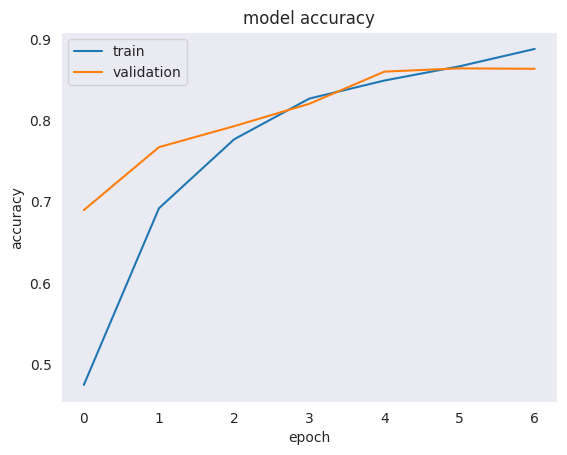

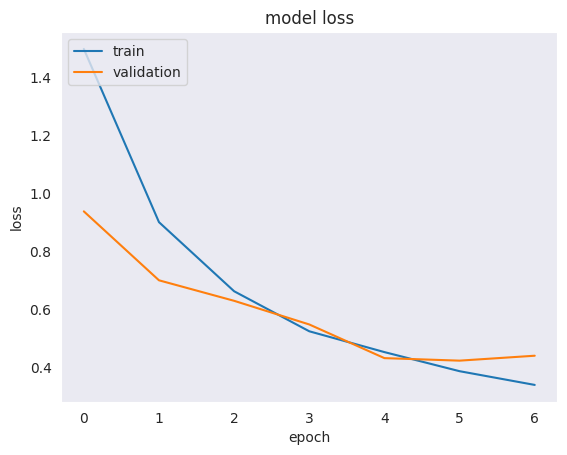

In [42]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Model Evaluation and Performance Metrics

In [43]:
Y_pred = model.predict(X_test)
Y_pred = [np.argmax(i) for i in Y_pred]
y_test = [np.argmax(i) for i in y_test]

55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step


In [44]:
print(classification_report(y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.95      0.86      0.90       203
           1       0.74      0.98      0.84        86
           2       0.73      0.84      0.78       183
           3       0.88      0.85      0.86       201
           4       0.91      0.83      0.87       206
           5       0.95      0.89      0.92       193
           6       0.85      0.92      0.88        72
           7       0.93      0.94      0.94       208
           8       0.74      0.99      0.85       165
           9       0.95      0.68      0.79       230

    accuracy                           0.86      1747
   macro avg       0.86      0.88      0.86      1747
weighted avg       0.88      0.86      0.86      1747

